#Word2Vec Model

1.  Importing the essential libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score

import emoji
import missingno as msno
import plotly_express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [ ]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Manasa\anaconda3\python.exe -m pip install --upgrade pip' command.


2. Read Data

In [ ]:
df = pd.read_csv("cyberbullying_tweets.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


3.   Analyzing the data

In [ ]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,@SFtheWolf did you read the text of the articl...,religion
freq,2,7998


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

4.   Cleaning the dataset: removing the duplicates

In [ ]:
df.duplicated().sum()

36

In [ ]:
df = df.drop_duplicates()
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

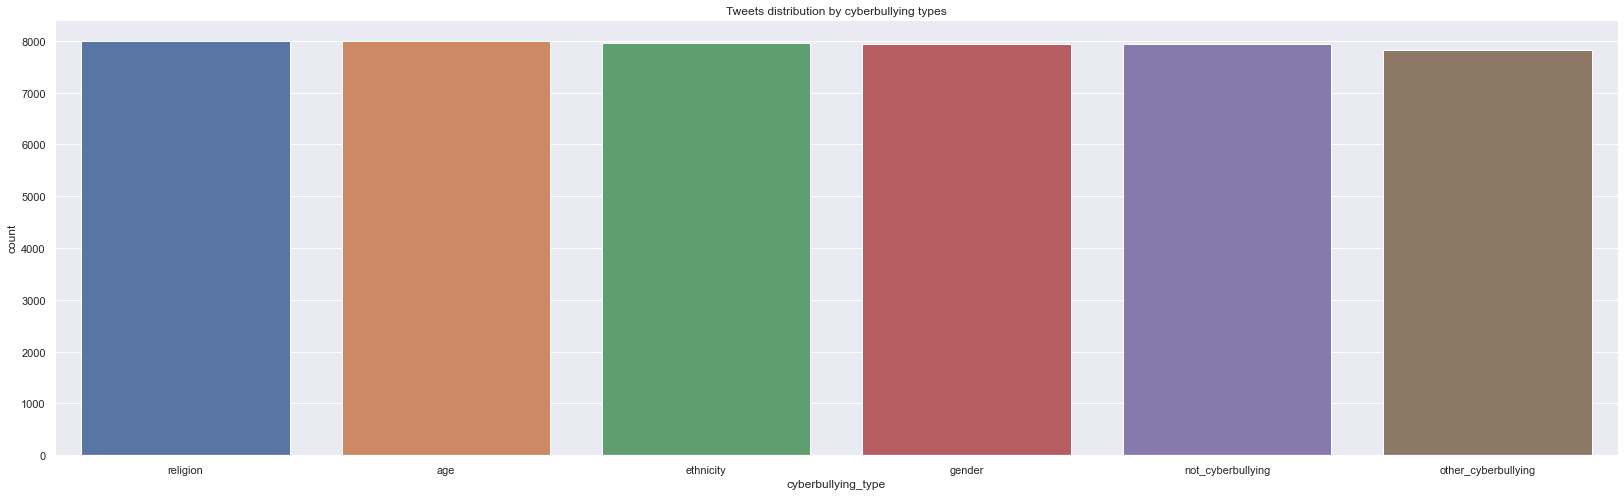

In [ ]:
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [ ]:
(df.cyberbullying_type.value_counts(normalize=True) * 100)

religion               16.780678
age                    16.770186
ethnicity              16.700940
gender                 16.677858
not_cyberbullying      16.654776
other_cyberbullying    16.415562
Name: cyberbullying_type, dtype: float64

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df["tweet_length"] = df.tweet_text.map(lambda x: len(x))
tweet_length_stats = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").mean()
tweet_length_stats["min"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").min().tweet_length
tweet_length_stats["max"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").max().tweet_length
tweet_length_stats

,tweet_length,min,max
cyberbullying_type,,,
age,173.542042,11,1585
ethnicity,139.302928,5,1869
gender,136.502139,2,1431
not_cyberbullying,83.085675,2,1809
other_cyberbullying,85.713281,1,5018
religion,197.982243,7,568


In [ ]:
df

,tweet_text,cyberbullying_type,tweet_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90


5. Creating Word Cloud

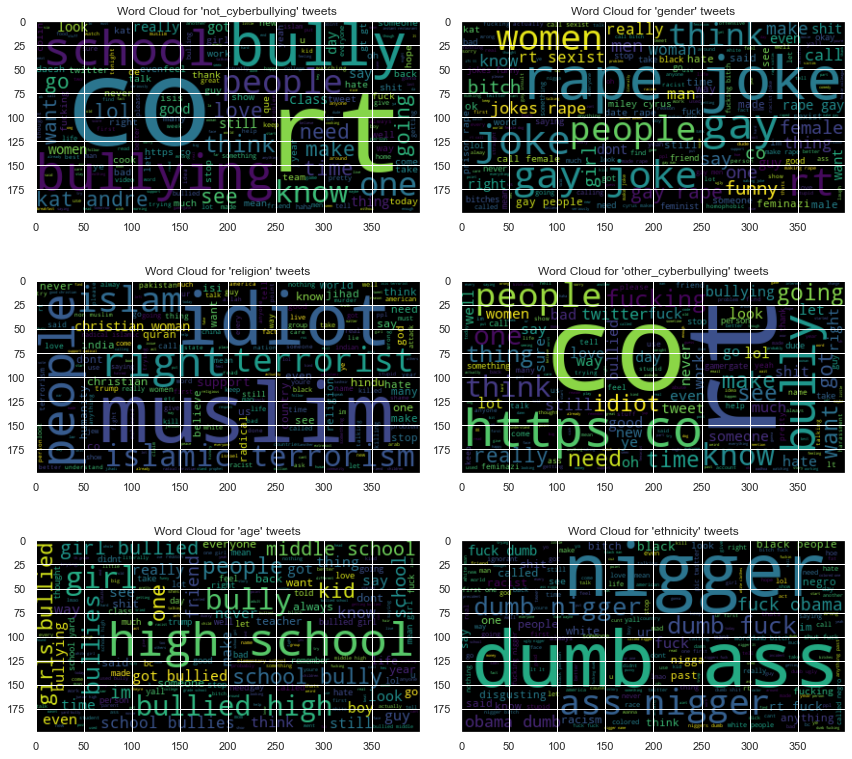

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 11))
k=0
for i in range(3):
    for j in range(2):
        cat = all_labels[k]
        wordcloud = WordCloud().generate(" ".join(data_df[data_df['cyberbullying_type']==cat]['clean_tweets'].tolist()))

        # Display the generated image:
        ax[i,j].imshow(wordcloud, interpolation='bilinear');
        ax[i,j].set_title("Word Cloud for '{}' tweets".format(cat));
        k+=1
fig.tight_layout();

In [ ]:
import gensim
from gensim.models import Word2Vec

6. Vectorization

In [ ]:
class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
    def fit(self, X, y):
        return self
    
tk = TweetTokenizer()

df["tokenized"] = [tk.tokenize(i) for i in df['tweet_text']]
model = Word2Vec(df["tokenized"], min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
modelw = MeanEmbeddingVectorizer(w2v)

In [ ]:
df["cyberbullying_type_code"] = df.cyberbullying_type.astype('category').cat.codes
df["cyberbullying_type_code"].unique()

array([3, 2, 5, 4, 0, 1], dtype=int8)

7. Splitting the dataset: Training dataset and Testing dataset 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["tokenized"],df["cyberbullying_type_code"],test_size=0.2,shuffle=True, stratify=df["cyberbullying_type"])

# Convert train and test sets to vectors
X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)

8. Model Building and Model Fitting

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    use_label_encoder=False,
    max_depth=4,
    min_child_weight=2,
    gamma=0.3,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.1
)
model.fit(X_train_vectors_w2v, y_train)

[11:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

9. Model Accuracy

In [ ]:
predictions = model.predict(X_test_vectors_w2v)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.690516156105749
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1598
           1       0.83      0.80      0.81      1592
           2       0.77      0.65      0.70      1590
           3       0.48      0.47      0.48      1587
           4       0.49      0.52      0.50      1565
           5       0.70      0.82      0.75      1600

    accuracy                           0.69      9532
   macro avg       0.69      0.69      0.69      9532
weighted avg       0.69      0.69      0.69      9532

